In [1]:
import os
import itertools

import pandas
import matplotlib
import seaborn
import lifelines

from scipy.stats import pointbiserialr, linregress
from lifelines.statistics import logrank_test

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (14, 3)
FIGURE_PATH = '../figures'
ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2018-01-01')
CENSOR_DATE = pandas.to_datetime('2018-03-15')
P_VALUE = 0.05  # Not corrected

PALETTE = seaborn.color_palette()
SEC_PALETTE = seaborn.color_palette('hls')
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

In [3]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def _savefig(fig, name):
    fig.savefig(
        os.path.join(FIGURE_PATH, '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

# Disable figure export
SAVEFIG = True
savefig = _savefig if SAVEFIG else lambda x, y: None

## Load data

In [4]:
df_versions = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_versions[ecosystem] = (
        pandas.read_csv(
            '../data/{}-versions.csv.gz'.format(ecosystem),
        )
        .assign(
            date=lambda d: pandas.to_datetime(d['date'], infer_datetime_format=True),
        )
    )
    
    print('.. identify next release')
    df_versions[ecosystem] = (
        df_versions[ecosystem]
        .merge(
            (
                df_versions[ecosystem]
                .assign(rank=lambda d: d['rank'] - 1)
                .rename(columns={'date': 'next_date'})
                [['package', 'rank', 'next_date']]
            ),
            how='left',
            on=['package', 'rank']
        )
    )
    
print('Done!')

Loading Cargo
.. identify next release
Loading NPM
.. identify next release
Loading Packagist
.. identify next release
Loading Rubygems
.. identify next release
Done!


In [5]:
df_dependencies = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
        .merge(
            df_versions[ecosystem][['package', 'version', 'rank', 'date', 'next_date']],
            how='left',
            on=['package', 'version']
        )
       .assign(**{
            'patch': lambda d: d['allows_patch'],
            'minor': lambda d: d['allows_minor'],
            'major': lambda d: d['allows_major'],
            'patch max': lambda d: d['allows_patch'] & ~d['allows_minor'],
            'minor max': lambda d: d['allows_minor'] & ~d['allows_major'],
            'other': lambda d: ~d['allows_patch']
        })
    )    
    
print('Done!')

Loading Cargo
Loading NPM
Loading Packagist
Loading Rubygems
Done!


In [6]:
df_constraints = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    
    df_tmp = df_dependencies[ecosystem].sort_values('rank')
    
    df_constraints[ecosystem] = (
        df_tmp
        .drop_duplicates(['package', 'target', 'constraint'], keep='first')
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target', 'constraint'], keep='last')
                [['package', 'target', 'constraint', 'rank', 'next_date']]
                .assign(next_rank=lambda d: (d['rank'] + 1).where(~d['next_date'].isnull()))
                .rename(columns={'next_date': 'constraint_next_date', 'next_rank': 'constraint_next_rank'})
                [['package', 'target', 'constraint', 'constraint_next_date', 'constraint_next_rank']]
            ),
            how='left',
            on=['package', 'target', 'constraint']
        )
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target'], keep='first')
                .assign(constraint_is_new=True)
                [['package', 'target', 'rank', 'constraint_is_new']]
            ),
            how='left',
            on=['package', 'target', 'rank']
        )
        .fillna({'constraint_is_new': False})
    )
print('Done!')

Loading Cargo
Loading NPM
Loading Packagist
Loading Rubygems
Done!


# Overview

## Number of packages, releases and dependencies

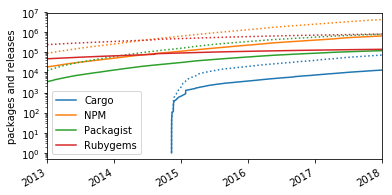

In [7]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()

for ecosystem in ECOSYSTEMS:
    df_tmp = (
        df_versions[ecosystem]
        .set_index('date')
        .sort_index()
    )
    
    data[ecosystem] = (
        df_tmp
        .drop_duplicates(['package'], keep='first')
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        ,
        df_tmp
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()        
    )
    
    data[ecosystem][0].plot(ax=ax, color=COLORS[ecosystem])
    data[ecosystem][1].plot(ax=ax, legend=False, style=':', color=COLORS[ecosystem])
    
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='packages and releases',
    yscale='log', 
)

savefig(fig, 'overview_number_packages_releases')

In [8]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem, data[ecosystem][0].max().values, data[ecosystem][1].max().values)

Cargo [14491] [80778]
NPM [698647] [4432172]
Packagist [126363] [832899]
Rubygems [143737] [825386]


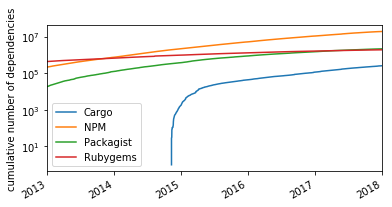

In [9]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='cumulative number of dependencies',
    yscale='log', 
)

savefig(fig, 'overview_number_dependencies')

In [10]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem, data[ecosystem].max().values)

Cargo [292470]
NPM [19838481]
Packagist [2273465]
Rubygems [1970396]


## Monthly proportion of valid dependencies

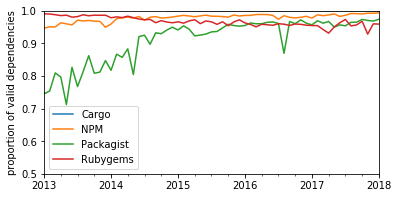

In [11]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(version=1)        
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['empty', 'version']]
        .sum()
        .assign(**{ecosystem: lambda d: (d['version'] - d['empty']) / d['version']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of valid dependencies',
    ylim=(0.5, 1.00),
)

savefig(fig, 'overview_proportion_valid_dependencies')

In [12]:
for ecosystem in ECOSYSTEMS:
    print(data[ecosystem].describe())

           Cargo
count  41.000000
mean    0.999993
std     0.000030
min     0.999837
25%     1.000000
50%     1.000000
75%     1.000000
max     1.000000
             NPM
count  89.000000
mean    0.972722
std     0.035544
min     0.666667
25%     0.968587
50%     0.979999
75%     0.985679
max     0.997467
       Packagist
count  80.000000
mean    0.894191
std     0.085402
min     0.672662
25%     0.816298
50%     0.935748
75%     0.961074
max     1.000000
         Rubygems
count  163.000000
mean     0.973887
std      0.021013
min      0.840830
25%      0.962832
50%      0.977578
75%      0.986885
max      1.000000


# Dependency constraint usage

## Monthly proportion allowing major, minor or patch

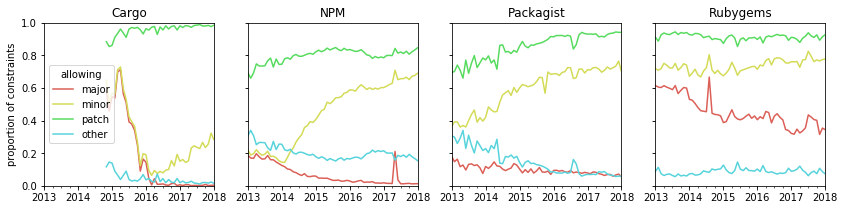

In [13]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

columns = ['major', 'minor', 'patch', 'other']

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [columns + ['n']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
        [columns]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=SEC_PALETTE)
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='proportion of constraints',
        ylim=(0, 1),
    )
    
axes[0].legend(title='allowing', loc='center left')
savefig(fig, 'usage_major_minor_patch')

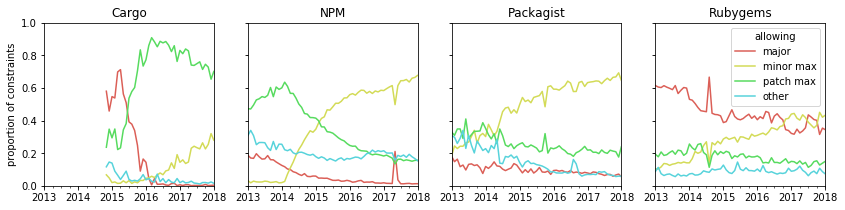

In [14]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

columns = ['major', 'minor max', 'patch max', 'other']

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [columns + ['n']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
        [columns]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=SEC_PALETTE)
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='proportion of constraints',
        ylim=(0, 1),
    )
    
axes[3].legend(title='allowing', ncol=1)
savefig(fig, 'usage_major_minor_patch_only')

## Monthly proportion of pre-1.0.0 updates

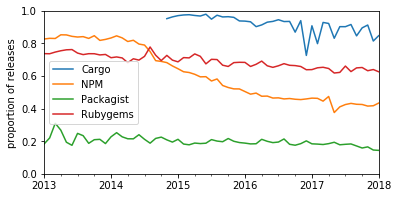

In [15]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_versions[ecosystem]
        .assign(zero=lambda d: d['version'].str.startswith('0.'))
        .assign(version=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['version', 'zero']]
        .sum()
        .assign(**{ecosystem: lambda d: d['zero'] / d['version']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of releases',
    ylim=(0, 1),
)

savefig(fig, 'update_proportion_development')

# Package updates

## Monthly number of updates

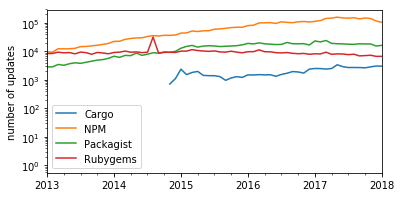

In [16]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_versions[ecosystem]
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['version']]
        .count()
        .rename(columns={'version': ecosystem})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='number of updates',
    yscale='log',
)

savefig(fig, 'update_number_by_month')

## Monthly proportion of major, minor and patch

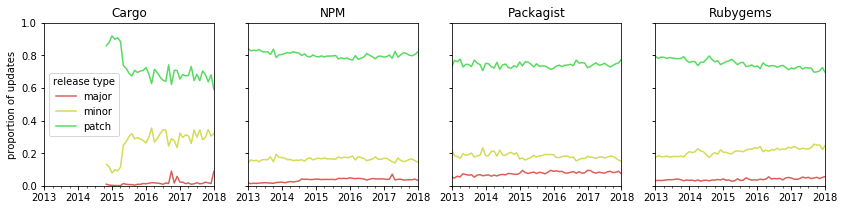

In [17]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

columns = ['major', 'minor', 'patch']

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_versions[ecosystem]
        [lambda d: d['type'] != 'initial']
        .assign(
            patch=lambda d: d['type'] == 'patch',
            minor=lambda d: d['type'] == 'minor',
            major=lambda d: d['type'] == 'major',
        )
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [columns + ['n']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
        [columns]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=SEC_PALETTE)
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='proportion of updates',
        ylim=(0, 1),
    )
    
axes[0].legend(title='release type')
savefig(fig, 'update_proportion_by_month')

## Duration of a release

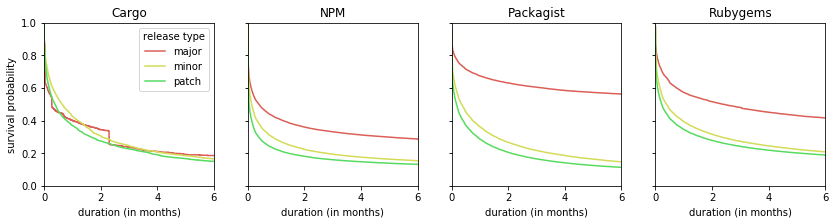

In [18]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_versions[ecosystem]
        [lambda d: d['type'] != 'initial']
        .assign(duration=lambda d: (d['next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, 'days'))
        .assign(observed=lambda d: ~d['next_date'].isnull())
    )
    
    kmf = lifelines.KaplanMeierFitter()
    for j, release_type in enumerate(['major', 'minor', 'patch']):
        mask = data[ecosystem]['type'] == release_type
        kmf.fit(data[ecosystem][mask]['duration'], data[ecosystem][mask]['observed'], label=release_type)
        kmf.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False)
    
    ax.set(
        title=ecosystem,
        xlabel='duration (in months)',
        xlim=(0, 6),
        ylabel='survival probability',
        ylim=(0, 1),         
    )
    
axes[0].legend(title='release type')
savefig(fig, 'update_release_duration_survival')

In [19]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    for A, B in itertools.combinations(['major', 'minor', 'patch'], 2):
        mask_A = data[ecosystem]['type'] == A
        mask_B = data[ecosystem]['type'] == B
        
        try:
            test = logrank_test(
                data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                alpha=0.95,
            )
            print('{} vs {}: {} ({:e})'.format(A, B, (test.p_value < P_VALUE), test.p_value))
        except AssertionError:  # Don't know why lifelines do this?
            print('{} vs {}: passed'.format(A, B))

Cargo
major vs minor: False (1.254932e-01)
major vs patch: False (8.224291e-02)
minor vs patch: True (3.424414e-29)
NPM
major vs minor: True (0.000000e+00)
major vs patch: True (0.000000e+00)
minor vs patch: passed
Packagist
major vs minor: True (0.000000e+00)
major vs patch: True (0.000000e+00)
minor vs patch: True (0.000000e+00)
Rubygems
major vs minor: True (0.000000e+00)
major vs patch: True (0.000000e+00)
minor vs patch: True (3.201213e-179)


## Duration of a release w.r.t. used constraints

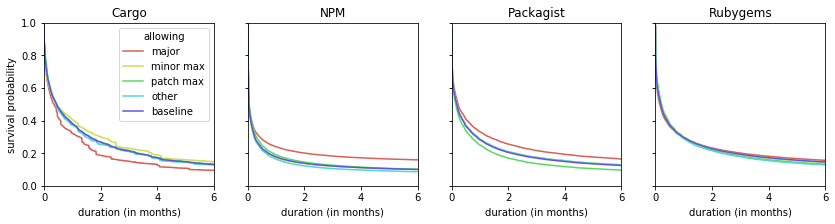

In [20]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(duration=lambda d: (d['next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, 'days'))
        .assign(observed=lambda d: ~d['next_date'].isnull())
        .assign(baseline=True)
    )
    
    kmf = lifelines.KaplanMeierFitter()
    for j, constraint_type in enumerate(['major', 'minor max', 'patch max', 'other', 'baseline']):
        mask = data[ecosystem][constraint_type]
        kmf.fit(data[ecosystem][mask]['duration'], data[ecosystem][mask]['observed'], label=constraint_type)
        kmf.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False)
    
    ax.set(
        title=ecosystem,
        xlabel='duration (in months)',
        xlim=(0, 6),
        ylabel='survival probability',
        ylim=(0, 1),         
    )
    
axes[0].legend(title='allowing', ncol=1)
savefig(fig, 'update_duration_major_minor_patch')

In [21]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    for A, B in itertools.combinations(['major', 'minor max', 'patch max', 'other', 'baseline'], 2):
        mask_A = data[ecosystem][A]
        mask_B = data[ecosystem][B]
        
        try:
            test = logrank_test(
                data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                alpha=0.95,
            )
            print('{} vs {}: {} ({:e})'.format(A, B, (test.p_value < P_VALUE), test.p_value))
        except AssertionError:  # Don't know why lifelines do this?
            print('{} vs {}: passed'.format(A, B))

Cargo
major vs minor max: True (1.261141e-91)
major vs patch max: True (2.182882e-76)
major vs other: True (9.899995e-19)
major vs baseline: True (1.721542e-72)
minor max vs patch max: True (5.484383e-09)
minor max vs other: True (4.709525e-06)
minor max vs baseline: True (8.306040e-13)
patch max vs other: True (1.947611e-02)
patch max vs baseline: False (6.232988e-02)
other vs baseline: False (6.768016e-02)
NPM
major vs minor max: passed
major vs patch max: True (0.000000e+00)
major vs other: True (0.000000e+00)
major vs baseline: passed
minor max vs patch max: passed
minor max vs other: passed
minor max vs baseline: passed
patch max vs other: True (0.000000e+00)
patch max vs baseline: passed
other vs baseline: passed
Packagist
major vs minor max: True (0.000000e+00)
major vs patch max: True (0.000000e+00)
major vs other: True (2.484491e-235)
major vs baseline: True (0.000000e+00)
minor max vs patch max: True (0.000000e+00)
minor max vs other: False (5.594495e-01)
minor max vs baselin

# Constraint changes

## Number of changes

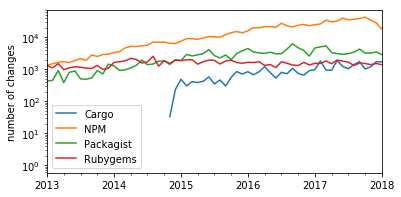

In [22]:
fig, ax = matplotlib.pyplot.subplots()

df_temp = pandas.concat([
    (
        df_constraints[ecosystem]
        [lambda d: ~d['constraint_is_new']]
        .merge(
            df_versions[ecosystem]
            [['package', 'rank', 'type']],
            how='left',
            on=['package', 'rank']
        )
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['version']]
        .count()
        .assign(ecosystem=ecosystem)
    ) for ecosystem in ECOSYSTEMS
])

(
    df_temp
    .pivot(columns='ecosystem', values='version')
    [ECOSYSTEMS]
    .plot(color=[COLORS[e] for e in ECOSYSTEMS], ax=ax)
)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='number of changes',
    yscale='log',
)

ax.legend(title=None)

savefig(fig, 'change_number_evolution')

In [23]:
(
    df_temp
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .set_index('date')
    .pivot(columns='ecosystem', values='version')
    .describe()
)

ecosystem,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,833.394737,14671.366667,2499.800000,1557.733333
std,450.522432,11890.138134,1411.402846,318.636548
min,33.000000,1330.000000,383.000000,971.000000
25%,498.000000,4988.500000,1307.250000,1317.000000
50%,793.500000,10192.500000,2720.500000,1540.500000
75%,1026.250000,22948.750000,3329.750000,1793.250000
max,1889.000000,42263.000000,6252.000000,2546.000000


## Release type when a constraint is changed

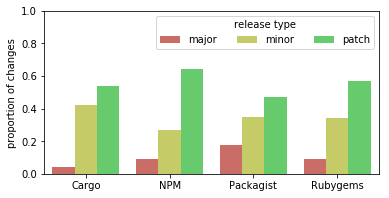

In [24]:
fig, ax = matplotlib.pyplot.subplots()

df_temp = pandas.concat([
    (
        df_constraints[ecosystem]
        [lambda d: ~d['constraint_is_new']]
        .merge(
            df_versions[ecosystem]
            [['package', 'rank', 'type']],
            how='left',
            on=['package', 'rank']
        )
        .groupby('type')
        [['version']]
        .count()
        .apply(lambda s: s / s.sum(), axis=0)
        .reset_index()
        .rename(columns={'version': 'proportion'})
        .assign(ecosystem=ecosystem)
    ) for ecosystem in ECOSYSTEMS
])

seaborn.barplot(
    x='ecosystem',
    y='proportion', 
    hue='type',
    order=ECOSYSTEMS,
    hue_order=['major', 'minor', 'patch'],
    data=df_temp,
    palette=SEC_PALETTE,
    ax=ax
)

ax.set(
    xlabel='', 
    ylabel='proportion of changes',
    ylim=(0, 1)
)

ax.legend(title='release type', ncol=3)

savefig(fig, 'change_proportion_changed_in')

## Proportion of release by type with a changed constraint

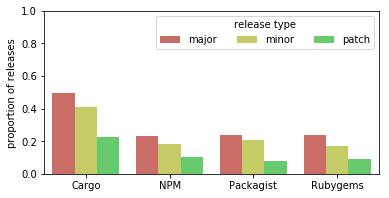

In [25]:
fig, ax = matplotlib.pyplot.subplots()

df_temp = pandas.concat([
    pandas.concat([
        (
            df_constraints[ecosystem]
            [lambda d: ~d['constraint_is_new']]
            .merge(
                df_versions[ecosystem]
                [['package', 'rank', 'type']],
                how='left',
                on=['package', 'rank']
            )
            .drop_duplicates(['package', 'version'])
            .groupby('type')
            [['version']]
            .count()
        ),
        (
            df_versions[ecosystem]
            [lambda d: d['type'] != 'initial']
            [['type']]
            .assign(total=1)
            .groupby(['type'])
            .count()
        )],
        axis=1
    )
    .reset_index()
    .assign(proportion=lambda d: d['version'] / d['total'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS
])

seaborn.barplot(
    x='ecosystem',
    y='proportion', 
    hue='type',
    order=ECOSYSTEMS,
    hue_order=['major', 'minor', 'patch'],
    data=df_temp,
    palette=SEC_PALETTE,
    ax=ax
)

ax.set(
    xlabel='', 
    ylabel='proportion of releases',
    ylim=(0, 1)
)

ax.legend(ncol=3, title='release type')

savefig(fig, 'change_proportion_release_with_change')

## Duration of a constraint

Restrict to packages sufficiently updated. 
We consider the median value as a threshold:

In [26]:
df_frequently_updated = dict()

for ecosystem in ECOSYSTEMS:
    df_temp = (
        df_versions[ecosystem]
        .sort_values('rank')
        .drop_duplicates('package', keep='last')
        [lambda e: e['rank'] > e['rank'].median()]
    )
    print(ecosystem, df_temp['rank'].min())
    df_frequently_updated[ecosystem] = df_temp['package']

Cargo 4
NPM 4
Packagist 4
Rubygems 3


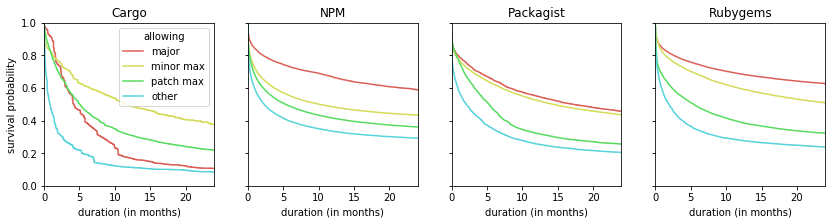

In [27]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        [lambda d: d['package'].isin(df_frequently_updated[ecosystem])]
        .assign(duration=lambda d: (d['constraint_next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, 'days'))
        .assign(observed=lambda d: ~d['constraint_next_date'].isnull())
    )
    
    kmf = lifelines.KaplanMeierFitter()
    for j, constraint_type in enumerate(['major', 'minor max', 'patch max', 'other']):
        mask = data[ecosystem][constraint_type]
        kmf.fit(data[ecosystem][mask]['duration'], data[ecosystem][mask]['observed'], label=constraint_type)
        kmf.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False)
    
    ax.set(
        title=ecosystem,
        xlabel='duration (in months)',
        xlim=(0, 24),
        ylabel='survival probability',
        ylim=(0, 1),         
    )
    
axes[0].legend(title='allowing', ncol=1)
savefig(fig, 'change_duration_major_minor_patch')

In [28]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    for A, B in itertools.combinations(['major', 'minor max', 'patch max', 'other'], 2):
        mask_A = data[ecosystem][A]
        mask_B = data[ecosystem][B]
        
        try:
            test = logrank_test(
                data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                alpha=0.95,
            )
            print('{} vs {}: {} ({:e})'.format(A, B, (test.p_value < P_VALUE), test.p_value))
        except AssertionError:  # Don't know why lifelines do this?
            print('{} vs {}: passed'.format(A, B))

Cargo
major vs minor max: True (6.569912e-176)
major vs patch max: True (1.063308e-32)
major vs other: True (8.262098e-166)
minor max vs patch max: True (4.658534e-141)
minor max vs other: True (0.000000e+00)
patch max vs other: True (0.000000e+00)
NPM
major vs minor max: True (0.000000e+00)
major vs patch max: True (0.000000e+00)
major vs other: True (0.000000e+00)
minor max vs patch max: True (0.000000e+00)
minor max vs other: True (0.000000e+00)
patch max vs other: True (0.000000e+00)
Packagist
major vs minor max: True (7.286273e-11)
major vs patch max: True (0.000000e+00)
major vs other: True (0.000000e+00)
minor max vs patch max: True (0.000000e+00)
minor max vs other: True (0.000000e+00)
patch max vs other: True (0.000000e+00)
Rubygems
major vs minor max: True (0.000000e+00)
major vs patch max: True (0.000000e+00)
major vs other: True (0.000000e+00)
minor max vs patch max: True (0.000000e+00)
minor max vs other: True (0.000000e+00)
patch max vs other: True (0.000000e+00)


## Proportion of changes by original and new constraint (2017)

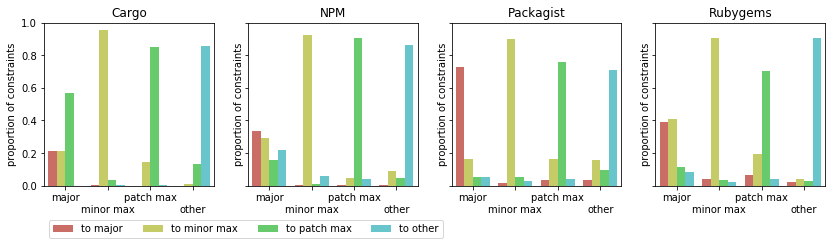

In [29]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        [lambda d: d['date'].between(pandas.to_datetime('2017-01-01'), pandas.to_datetime('2018-01-01'))]
        .assign(
           kind=lambda d: d[['major', 'minor max', 'patch max', 'other']].apply(lambda s: s.values.argmax(), axis=1)
        )
        .pipe(lambda d: 
            d[['package', 'target', 'kind', 'constraint_next_rank']]
            .merge(
                d[['package', 'target', 'kind', 'rank']],
                how='inner',
                left_on=['package', 'target', 'constraint_next_rank'],
                right_on=['package', 'target', 'rank'],
                suffixes=('', '_new'),
            )        
        )
        .assign(n=1)
        .groupby(['kind', 'kind_new'], as_index=False)
        [['n']]
        .count()
        .replace({
            'kind': {0: 'major', 1: '\nminor max', 2: 'patch max', 3: '\nother'},
            'kind_new': {0: 'to major', 1: 'to minor max', 2: 'to patch max', 3: 'to other'},
        })
        .pivot('kind', 'kind_new', 'n')
        .apply(lambda s: s / s.sum(), axis=1)    
    )

    seaborn.barplot(
        data=(
            data[ecosystem]
            .reset_index()
            .pipe(lambda d: 
                pandas.melt(d, 'kind', value_vars=['to major', 'to minor max', 'to patch max', 'to other'])
            )
        ),
        x='kind',
        y='value',
        hue='kind_new',
        order=['major', '\nminor max', 'patch max', '\nother'],
        hue_order=['to major', 'to minor max', 'to patch max', 'to other'],
        palette=SEC_PALETTE,
        ax=ax,
    )
    ax.legend().remove()
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='proportion of constraints',
        ylim=(0, 1),
    )

axes[0].legend(ncol=4, loc='lower left', bbox_to_anchor=(0, -0.35))
savefig(fig, 'change_from_to')

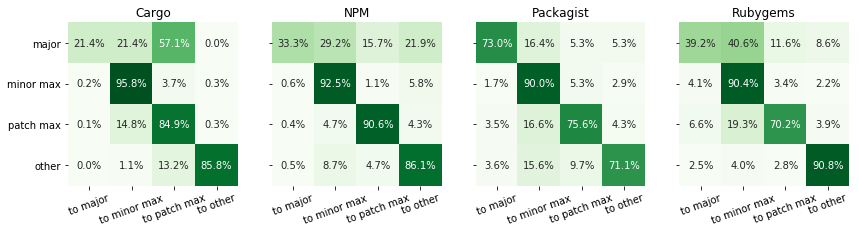

In [30]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]

    seaborn.heatmap(
        (
            data[ecosystem]
            .reset_index()
            .replace({'\nminor max': 'minor max', '\nother': 'other'})
            .set_index('kind')
            .fillna(0)
            [['to major', 'to minor max', 'to patch max', 'to other']]
            .loc[['major', 'minor max', 'patch max', 'other']]
        ),
        annot=True, 
        cmap='Greens',
        cbar=False,
        fmt='.1%',
        center=0.5,
        ax=ax
    )
    
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)
        # tick.set_horizontalalignment('right')
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='',
    )
    
savefig(fig, 'change_from_to_heatmap')

## Time to soften a constraint

In [31]:
# From first non-soft to first soft

## Time to harden a constraint

In [32]:
# From first non-hard to first hard

# Constraint specialization

## "Decidable" constraints

Proportion of required packages with a proportion of constraints very low or very high (ie. "decidable").

Only the latest snapshot is considered. 

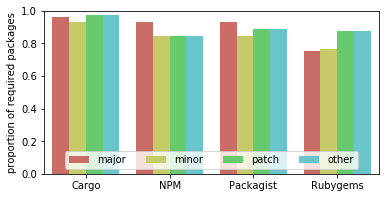

In [33]:
fig, ax = matplotlib.pyplot.subplots()

threshold = (0.05, 0.95)

df_temp = pandas.DataFrame(index=ECOSYSTEMS, columns=['major', 'minor', 'patch', 'other'])

for ecosystem in ECOSYSTEMS:
    df_temp.loc[ecosystem] = (
        df_dependencies[ecosystem]
        .sort_values('rank')
        .drop_duplicates(['package', 'target'], keep='last')
        .assign(dependents=1)
        .groupby(['target'], sort=False)
        [['dependents', 'major', 'minor', 'patch', 'other']]
        .sum()
        #[lambda d: d['dependents'] > 1]
        #[lambda d: d['dependents'] >= d['dependents'].median()]
        .pipe(lambda d:
             d.apply(lambda s: s / d['dependents'])
        )
        .apply(lambda s: ~s.between(*threshold))
        .apply(lambda s: s.sum() / len(s))
        [['major', 'minor', 'patch', 'other']]
    )
    
seaborn.barplot(
    data=(
        df_temp
        .reset_index()
        .pipe(pandas.melt, 'index', var_name='constraint', value_name='proportion')
        .rename(columns={'index': 'ecosystem'})
    ),
    x='ecosystem',
    y='proportion',
    hue='constraint',
    order=ECOSYSTEMS,
    hue_order=['major', 'minor', 'patch', 'other'],
    palette=SEC_PALETTE,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='proportion of required packages',
    ylim=(0, 1),
)

ax.legend(loc='lower center', ncol=4)

savefig(fig, 'required_specialization_threshold')

## Specialization/decidability (threshold)

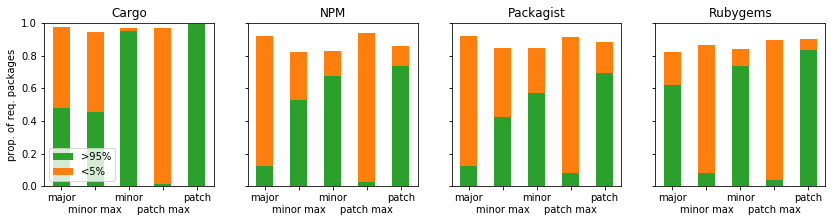

In [34]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

threshold = (0.05, 0.95)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        .sort_values('rank')
        .drop_duplicates(['package', 'target'], keep='last')
        .assign(dependents=1)
        .groupby(['target'], sort=False)
        [['dependents', 'major', 'minor max', 'minor', 'patch max', 'patch']]
        .sum()
        #[lambda d: d['dependents'] > 1]
        #[lambda d: d['dependents'] >= d['dependents'].median()]
        .pipe(lambda d:
             d.apply(lambda s: s / d['dependents'])
        )
        .pipe(pandas.melt, value_vars=['major', 'minor max', 'minor', 'patch max', 'patch'], var_name='constraint', value_name='proportion')
        .assign(
            above=lambda d: d['proportion'] > threshold[1],
            below=lambda d: d['proportion'] < threshold[0],
            inside=lambda d: d['proportion'].between(*threshold),
        )
        .groupby('constraint', sort=False)
        [['above', 'inside', 'below']]
        .sum()
        .apply(lambda s: s / s.sum(), axis=1)
        .reset_index()
    )
    
    (
        data[ecosystem]
        [['constraint', 'above', 'below']]
        .rename(columns={
            'above': '>{:.0%}'.format(threshold[1]), 
            #'inside': '{:.0%}-{:.0%}'.format(*threshold), 
            'below': '<{:.0%}'.format(threshold[0])
        })
        .replace({'minor max': '\nminor max', 'patch max': '\npatch max'})
        .plot.bar(x='constraint', stacked=True, color=(PALETTE[2], PALETTE[1]), ax=ax)
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='prop. of req. packages',
        ylim=(0, 1),
    )
    ax.legend().remove()
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

axes[0].legend(loc='lower left')
savefig(fig, 'required_specialization_accept_reject_stacked')

In [35]:
pandas.concat([
    (
        df
        .assign(ecosystem=ecosystem)
        
    )
    for ecosystem, df in data.items()
])[['ecosystem', 'constraint', 'above', 'below', 'inside']]

,ecosystem,constraint,above,below,inside
0,NPM,major,0.121727,0.797748,0.080525
1,NPM,minor max,0.527802,0.295503,0.176695
2,NPM,minor,0.677634,0.154088,0.168278
3,NPM,patch max,0.027287,0.915038,0.057674
4,NPM,patch,0.735754,0.124073,0.140173
0,Packagist,major,0.123961,0.798123,0.077916
1,Packagist,minor max,0.423980,0.422601,0.153419
2,Packagist,minor,0.571232,0.278031,0.150737
3,Packagist,patch max,0.081249,0.833327,0.085424
4,Packagist,patch,0.696840,0.189121,0.114039


In [36]:
for ecosystem in ECOSYSTEMS:
    _ = (
        df_dependencies[ecosystem]
        .sort_values('rank')        
    )
    a, b = len(_.drop_duplicates(['package', 'target'], keep='last')), len(_[lambda d: ~d['dev']].drop_duplicates(['package', 'target'], keep='last'))
    print(
        ecosystem, 
        a, b, b / a
    )

Cargo 48541 14059 0.28963144558208526
NPM 2240968 1719321 0.7672224681476933
Packagist 266417 245831 0.9227301561086567
Rubygems 241662 211847 0.8766252037970388


## Evolution of the "specialized" required packages

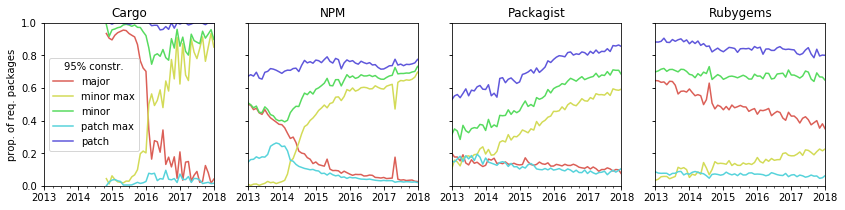

In [37]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

threshold = 0.95

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        .assign(deps=1)
        .groupby(['target', pandas.Grouper(key='date', freq='M')], sort=False)
        [['major', 'minor max', 'minor', 'patch max', 'patch', 'deps']]
        .sum()
        .reset_index(level='date')
        .set_index('date')
        .assign(**{
            'major': lambda d: d['major'] >= threshold * d['deps'],
            'minor max': lambda d: d['minor max'] >= threshold * d['deps'],
            'minor': lambda d: d['minor'] >= threshold * d['deps'],
            'patch max': lambda d: d['patch max'] >= threshold * d['deps'],            
            'patch': lambda d: d['patch'] >= threshold * d['deps'],
        })
        .assign(required=1)
        .groupby(level='date')
        .sum()
    )
    
    (
        data[ecosystem]
        .apply(lambda d: d / d['required'], axis=1)
        [['major', 'minor max', 'minor', 'patch max', 'patch']]
        .plot(ax=ax, legend=False, color=SEC_PALETTE)
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of req. packages',
        ylim=(0, 1),
    )
    
axes[0].legend(loc='center left', ncol=1, title='{:.0%} constr.'.format(threshold))
savefig(fig, 'required_proportion_by_month')

In [38]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    print(
        data[ecosystem]
        .apply(lambda d: d / d['required'], axis=1)
        .iloc[-1]
        [['major', 'minor max', 'minor', 'patch max', 'patch']]
    )
    print()

Cargo
major        0.065217
minor max    0.855072
minor        0.934783
patch max    0.007246
patch        1.000000
Name: 2018-03-31 00:00:00, dtype: float64

NPM
major        0.014372
minor max    0.742625
minor        0.761346
patch max    0.019667
patch        0.805787
Name: 2018-03-31 00:00:00, dtype: float64

Packagist
major        0.067898
minor max    0.642042
minor        0.726779
patch max    0.101032
patch        0.884845
Name: 2018-03-31 00:00:00, dtype: float64

Rubygems
major        0.383507
minor max    0.212970
minor        0.678143
patch max    0.079263
patch        0.837470
Name: 2018-03-31 00:00:00, dtype: float64



## Preferential attachment

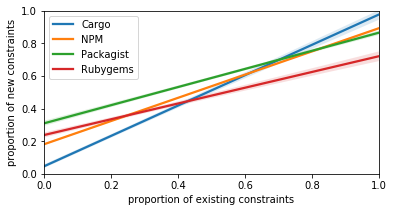

In [39]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)

threshold = '2017-01-01'
data = dict()

for ecosystem in ECOSYSTEMS: 
    df_temp_1 = (
        df_constraints[ecosystem]
        # [lambda d: ~d['dev']]
        [lambda d: d['date'] < pandas.to_datetime(threshold)]
        .drop_duplicates(['package', 'target'], keep='last')
        [['target', 'minor max']]
        .assign(dependents=1)
        .groupby('target')
        .sum()
        .pipe(lambda d: d['minor max'] / d['dependents'])
    )

    df_temp_2 = (
        df_constraints[ecosystem]
        # [lambda d: ~d['dev']]
        [lambda d: d['date'] >= pandas.to_datetime(threshold)]
        .drop_duplicates(['package', 'target'], keep='last')
        [['target', 'minor max']]
        .assign(dependents=1)
        .groupby('target')
        .sum()
        .pipe(lambda d: d['minor max'] / d['dependents'])
    )

    data[ecosystem] = (
        pandas.concat([df_temp_1, df_temp_2], axis=1)
        .dropna()
        .rename(columns={0: 'original', 1: 'added'})
    )
    
    seaborn.regplot(
        x='original',
        y='added',
        data=data[ecosystem],
        color=COLORS[ecosystem],
        scatter=False,
        label=ecosystem,
        ax=ax,
    )
    
ax.set(
    xlabel='proportion of existing constraints',
    ylabel='proportion of new constraints',
    xlim=(0, 1),
    ylim=(0, 1),
)

ax.legend()
savefig(fig, 'required_pref_attach')

In [40]:
print('ecosystem ; slope ; intercept ; r_value (corr) ; p_value')
for ecosystem in ECOSYSTEMS:
    slope, intercept, r_value, p_value, std_err = linregress(data[ecosystem]['original'], data[ecosystem]['added'])    
    print('{:9}: {:.4f} {:.4f} {:.4f} {:.4f}'.format(ecosystem, slope, intercept, r_value, p_value))

ecosystem ; slope ; intercept ; r_value (corr) ; p_value
Cargo    : 0.9306 0.0461 0.8535 0.0000
NPM      : 0.7114 0.1812 0.6965 0.0000
Packagist: 0.5557 0.3096 0.5367 0.0000
Rubygems : 0.4833 0.2377 0.3925 0.0000
